In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
from sklearn.metrics import roc_curve

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
feature_type = '5e-4_qval'
in_dir = '../../MBC/ATAC_nucleosome_profiling/analysis/logreg_results/'+feature_type+'_logreg_results'
metadata_file = '../../metadata/MBC/merged_tables_revisions1/merged_key_metadata.txt'
iterations = 1000


In [3]:
#import data
probabilities = pd.read_csv(in_dir+'/'+feature_type+'.probabilities.txt', sep='\t')
AUC_CI = pd.read_csv(in_dir+'/'+feature_type+'.AUC_CI.txt', sep='\t')
AUC_CI = AUC_CI.rename(columns = {'Unnamed: 0':'group'})
accuracy_CI = pd.read_csv(in_dir+'/'+feature_type+'.accuracy_CI.txt', sep='\t')
accuracy_CI = accuracy_CI.rename(columns = {'Unnamed: 0':'group'})

probabilities = probabilities.set_index('sample')

#merge in additional metadata as needed
print(len(probabilities))

metadata = pd.read_csv(metadata_file,sep='\t').set_index('sample')
metadata_columns = list(metadata.columns)

probabilities = probabilities.merge(metadata, left_index=True, right_index=True)
print(len(probabilities))

probabilities = probabilities.rename(columns = {str(m):m for m in range(iterations)})

probabilities['median_probability'] = probabilities[range(iterations)].median(axis=1)
probabilities['median_prediction'] = np.round(probabilities['median_probability']).astype(int)
probabilities['median_accuracy'] = np.where(probabilities['median_prediction'] == probabilities['status'],1,0)

del(in_dir)

254
254


In [4]:
for_supplement = probabilities[metadata_columns+['median_probability','median_prediction']].drop(columns = ['TNBC_ULPWGS_ID', 'PatientID_09204', 'PatientID_05246']).copy()

rename_dict = {
    'merged_PrimaryEstrogenStatus':'primary_ER',
    'merged_MetsEstrogenStatus':'met_ER',
    'merged_ER_switch':'ER_switch',
    'revisions_ER_status':'ER_status',
    'revisions_ER_status_binary':'binary_ER_status',
    'first_passing_sample':'first_sample',
    'median_probability':'median_probability_ER+'}

for_supplement = for_supplement.rename(columns=rename_dict)
for_supplement = for_supplement[['patient_id', 'tumor_fraction', 'ulp_wgs_coverage', 'primary_ER',
       'met_ER', 'ER_switch', 'ER_status', 'binary_ER_status',
       'first_sample', 'median_probability_ER+', 'median_prediction']]

for_supplement.to_csv('files/S13_MBC_subtyping.tsv', sep='\t')



In [5]:
#get unique samples only
probabilities = probabilities[(probabilities['first_passing_sample']==1)]
print(len(probabilities))
#print number of unique patients
print('unique patients', len(probabilities['patient_id'].unique()))
print('first TFx >0.1',len(probabilities[probabilities['tumor_fraction']>=0.1]['patient_id'].unique()))

139
unique patients 139
first TFx >0.1 101


In [6]:
print('all patients')
print(probabilities['status'].value_counts())

print('high tfx')
print(probabilities[probabilities['tumor_fraction']>=0.1]['status'].value_counts())

print('low tfx')
print(probabilities[probabilities['tumor_fraction']<0.1]['status'].value_counts())

all patients
1    74
0    65
Name: status, dtype: int64
high tfx
0    51
1    50
Name: status, dtype: int64
low tfx
1    24
0    14
Name: status, dtype: int64


In [7]:
color_dict ={'low_tfx':'tab:olive','high_tfx':'tab:cyan', 'overall':'grey'}

0.6875 0.3808 0.92308
0.75 0.41667 1.0
0.86486 0.76471 0.95
0.92394 0.84188 0.9898
0.81132 0.69995 0.90385
0.89154 0.8106 0.95603


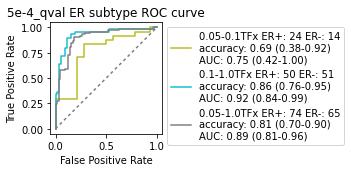

In [8]:
#plot the ROC curves 
fig,ax = plt.subplots(figsize=(6,2.5))

tfxs = [[.05,.1,'low_tfx'],[.1,1.0,'high_tfx'],[0.05,1.0,'overall']]


for minimum,maximum,name in tfxs:
    current = probabilities[(probabilities['tumor_fraction']>=minimum) & (probabilities['tumor_fraction']<maximum)]
    num_ER_pos = len(current[current['status']==1])
    num_ER_neg = len(current[current['status']==0])
    
    accuracy = accuracy_CI[(accuracy_CI['group']==name) ]['median']
    if not len(accuracy)==1:
        print('error')
    accuracy = accuracy.values[0]
    
    #get the CI from the bootstrap data
    lower_acc = accuracy_CI[(accuracy_CI['group']==name) ]['0.025'].values[0]
    upper_acc = accuracy_CI[(accuracy_CI['group']==name) ]['0.975'].values[0]
    
    print(accuracy,lower_acc,upper_acc)
    
    
    AUC = AUC_CI[(AUC_CI['group']==name)]['median']    
    if not len(AUC)==1:
        print('error')
    AUC = AUC.values[0]
    
    lower_AUC = AUC_CI[(AUC_CI['group']==name) ]['0.025'].values[0]
    upper_AUC = AUC_CI[(AUC_CI['group']==name) ]['0.975'].values[0]
    print(AUC,lower_AUC,upper_AUC)
    
    fpr, tpr, _ = roc_curve(current['status'].values,current['median_probability'])
    label = str(minimum)+'-'+str(maximum)+'TFx ER+: '+str(num_ER_pos)+' ER-: '+str(num_ER_neg)+\
        '\naccuracy: '+ format(accuracy,'.2f')+' ('+format(lower_acc, '.2f')+'-'+format(upper_acc, '.2f')+')'+\
        '\nAUC: '+ format(AUC,'.2f')+' ('+format(lower_AUC, '.2f')+'-'+format(upper_AUC, '.2f')+')'
    ax.plot(fpr,tpr, label = label, color=color_dict[name])

ax.legend(bbox_to_anchor = [1,1], loc = 'upper left')
ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title(feature_type+' ER subtype ROC curve')

ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('plots/'+feature_type+'_ROC_curves_by_tfx.pdf')

In [9]:
len(probabilities)

139

In [10]:
#below here only use tfx>0.1
probabilities = probabilities[probabilities['tumor_fraction']>=0.1]
print(len(probabilities))

101


In [11]:
pos_labels = ['+','borderline','low']
neg_labels = ['-']

In [12]:
#get AUC for subtype switchers vs non-subtype switchers
from sklearn.metrics import auc
ER_pos_primary = probabilities[(probabilities['merged_PrimaryEstrogenStatus'].isin(pos_labels)) & ~(probabilities['merged_MetsEstrogenStatus']=='none')]

ER_pos_primary_AUCs = []

all_indexes = []

for i in range(iterations):
    current = ER_pos_primary[~(ER_pos_primary[i].isnull())][['status','tumor_fraction',i]].copy()
    fpr,tpr,_ = roc_curve(current['status'],current[i])
    AUC = auc(fpr,tpr)
    ER_pos_primary_AUCs.append(AUC)
    
    all_indexes = np.concatenate((current.index,all_indexes))

subtype_switch_AUC = pd.Series({'median':pd.Series(ER_pos_primary_AUCs).median(),
      '0.025':pd.Series(ER_pos_primary_AUCs).quantile(0.025),
      '0.975':pd.Series(ER_pos_primary_AUCs).quantile(0.975)})

subtype_switch_AUC = np.round(subtype_switch_AUC,2)
print(subtype_switch_AUC)


/home/adoebley/.local/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:805: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


median    0.74
0.025     0.43
0.975     1.00
dtype: float64


1    41
0     9
Name: status, dtype: int64
0.7208672086720868


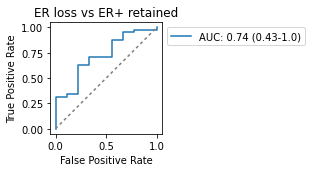

In [13]:
ER_pos_primary = probabilities[(probabilities['merged_PrimaryEstrogenStatus'].isin(pos_labels)) & ~(probabilities['merged_MetsEstrogenStatus']=='none')]
ER_pos_primary = ER_pos_primary[['status','median_probability','merged_PrimaryEstrogenStatus','merged_MetsEstrogenStatus']]
fpr, tpr, _ = roc_curve(ER_pos_primary['status'].values,ER_pos_primary['median_probability'])

print(ER_pos_primary['status'].value_counts())
print(auc(fpr,tpr))

label = 'AUC: '+subtype_switch_AUC['median'].astype(str)+' ('+\
subtype_switch_AUC['0.025'].astype(str)+'-'+\
subtype_switch_AUC['0.975'].astype(str)+')'

fig,ax = plt.subplots(figsize=(6,2.5))
ax.plot(fpr,tpr, label = label)
ax.set_aspect('equal')
ax.plot([0,1],[0,1], color = 'grey', dashes = (2,2))
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ER loss vs ER+ retained')
ax.legend(bbox_to_anchor = [1,1], loc = 'upper left')
len(ER_pos_primary)

plt.tight_layout()
fig.savefig('plots/ER+_vs_ER_loss.pdf')

In [14]:
status_col = 'revisions_ER_status_binary'
ER_negative_correct = probabilities[(probabilities['median_accuracy']==1) & (probabilities[status_col]=='-')]
print('ER- correct\t', len(ER_negative_correct))

ER_negative_wrong = probabilities[(probabilities['median_accuracy']==0) & (probabilities[status_col]=='-')]
print('ER- wrong\t',len(ER_negative_wrong))

ER_positive_correct = probabilities[(probabilities['median_accuracy']==1) & (probabilities[status_col]=='+')]
print('ER+ correct\t',len(ER_positive_correct))

ER_positive_wrong = probabilities[(probabilities['median_accuracy']==0) & (probabilities[status_col]=='+')]
print('ER+ wrong\t',len(ER_positive_wrong))

key_cols = ['tumor_fraction',status_col,'median_probability','merged_ER_switch','merged_updated_ER_status']


ER- correct	 45
ER- wrong	 6
ER+ correct	 45
ER+ wrong	 5


In [15]:
#print the ER- wrong samples
ER_negative_wrong[['tumor_fraction','revisions_ER_status','median_probability','merged_ER_switch']]

#Three are subtype switchers

,tumor_fraction,revisions_ER_status,median_probability,merged_ER_switch
sample,,,,
MBC_1099_4_ULP,0.1669,-,0.675990,loss
MBC_1158_ULP,0.5622,-,0.750875,loss
MBC_1370_1_ULP,0.1127,-,0.569615,same
MBC_1404_1_ULP,0.2463,-,0.902430,loss
MBC_1405_4_ULP,0.2956,-,0.660770,loss
MBC_331.ctDNA_ULP,0.4135,-,0.887850,loss


In [16]:
#print data about the ER negative correct samples
print(ER_negative_correct[['merged_ER_switch']].value_counts())
ER_negative_correct[ER_negative_correct['merged_ER_switch']=='loss']

merged_ER_switch
same                39
loss                 4
unknown              2
dtype: int64


,0,1,2,3,4,5,6,7,8,9,...,merged_MetsEstrogenStatus,merged_ER_switch,revisions_ER_status,revisions_ER_status_binary,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,median_probability,median_prediction,median_accuracy
sample,,,,,,,,,,,,,,,,,,,,,
MBC_1377_1_ULP,NaN,NaN,NaN,0.38431,NaN,NaN,NaN,NaN,NaN,NaN,...,-,loss,-,-,1193.0,1.0,1.0,0.484775,0,1
MBC_1406_3_ULP,NaN,NaN,NaN,NaN,NaN,NaN,0.49921,NaN,0.00022,NaN,...,-,loss,-,-,1268.0,1.0,1.0,0.028170,0,1
MBC_1408_ULP,NaN,NaN,0.0443,NaN,NaN,NaN,NaN,NaN,0.00926,0.09646,...,-,loss,-,-,635.0,1.0,1.0,0.096690,0,1
MBC_1412_1_ULP,0.01642,NaN,NaN,NaN,0.03074,NaN,NaN,NaN,NaN,NaN,...,-,loss,-,-,327.0,1.0,1.0,0.112485,0,1


In [17]:
#look at ER switch patients
probabilities[probabilities['merged_ER_switch']=='loss'][['tumor_fraction','revisions_ER_status','median_probability','median_prediction','merged_ER_switch','TNBC_ULPWGS_ID']]


,tumor_fraction,revisions_ER_status,median_probability,median_prediction,merged_ER_switch,TNBC_ULPWGS_ID
sample,,,,,,
MBC_1099_4_ULP,0.1669,-,0.675990,1,loss,TNBC_ULPWGS_135
MBC_1158_ULP,0.5622,-,0.750875,1,loss,NaN
MBC_1377_1_ULP,0.1504,-,0.484775,0,loss,TNBC_ULPWGS_30
MBC_1404_1_ULP,0.2463,-,0.902430,1,loss,TNBC_ULPWGS_73
MBC_1405_4_ULP,0.2956,-,0.660770,1,loss,TNBC_ULPWGS_14
MBC_1406_3_ULP,0.3620,-,0.028170,0,loss,TNBC_ULPWGS_96
MBC_1408_ULP,0.2757,-,0.096690,0,loss,TNBC_ULPWGS_86
MBC_1412_1_ULP,0.1416,-,0.112485,0,loss,TNBC_ULPWGS_66
MBC_331.ctDNA_ULP,0.4135,-,0.887850,1,loss,TNBC_ULPWGS_129


In [18]:
#perform a fishers exact test for ER- met switch vs no switch
no_switch_right = len(ER_negative_correct[ER_negative_correct['merged_ER_switch']=='same'])
switch_right = len(ER_negative_correct[ER_negative_correct['merged_ER_switch']=='loss'])

no_switch_wrong = len(ER_negative_wrong[ER_negative_wrong['merged_ER_switch']=='same'])
switch_wrong = len(ER_negative_wrong[ER_negative_wrong['merged_ER_switch']=='loss'])

contingency_table = [[no_switch_right,switch_right],[no_switch_wrong, switch_wrong]]
print(contingency_table)
del(no_switch_right,switch_right,no_switch_wrong, switch_wrong)
oddsratio, pvalue = stats.fisher_exact(contingency_table)
oddsratio, format(pvalue, '.1e')

[[39, 4], [1, 5]]


(48.75, '3.7e-04')

In [19]:
#perform a fishers exact test for ER- met switch vs ER pos
pos_pos_right = len(ER_positive_correct[ER_positive_correct['merged_ER_switch']=='same'])
switch_right = len(ER_negative_correct[ER_negative_correct['merged_ER_switch']=='loss'])

pos_pos_wrong = len(ER_positive_wrong[ER_positive_wrong['merged_ER_switch']=='same'])
switch_wrong = len(ER_negative_wrong[ER_negative_wrong['merged_ER_switch']=='loss'])

# contingency_table = [[pos_pos_right,switch_right],[pos_pos_wrong, switch_wrong]]
contingency_table = [[pos_pos_right,switch_wrong],[pos_pos_wrong, switch_right]]

print(contingency_table)
oddsratio, pvalue = stats.fisher_exact(contingency_table)
oddsratio, format(pvalue, '.1e')

[[36, 5], [5, 4]]


(5.76, '4.3e-02')

total 40 ER- pred 39 ER+ pred 1
total 9 ER- pred 4 ER+ pred 5
total 41 ER- pred 5 ER+ pred 36
total 1 ER- pred 0 ER+ pred 1


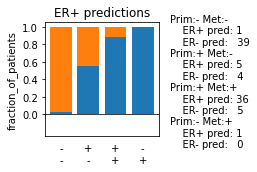

In [20]:
#show all four possible combinations
fig,ax = plt.subplots(figsize=(4,2.5))
padding = 0

pos_labels = ['+','borderline','low']
neg_labels = ['-']

for i,(prim,met) in enumerate([['-','-'],['+','-'],['+','+'],['-','+']]):
    if prim=='+':
        prim_labels = pos_labels
    else:
        prim_labels = neg_labels
    if met=='+':
        met_labels = pos_labels
    else:
        met_labels = neg_labels
    current = probabilities[(probabilities['merged_PrimaryEstrogenStatus'].isin(prim_labels)) & (probabilities['merged_MetsEstrogenStatus'].isin(met_labels))]
    group_label = prim+'\n'+met
    rect = ax.bar(group_label, 1, color = 'tab:orange', label = 'predicted_ER_negative', width = 0.8)
    #ax.bar_label(rect, [len(current) - sum(current['median_prediction'])], padding=padding)
    rect = ax.bar(group_label, current['median_prediction'].mean(), color = 'tab:blue', label = 'predicted_ER_positive', width = 0.8)
    #ax.bar_label(rect, [sum(current['median_prediction'])], padding=padding)
    print('total',len(current),'ER- pred',len(current) - sum(current['median_prediction']),'ER+ pred',sum(current['median_prediction']))
    text = 'Prim:'+prim+' Met:'+met+\
    '\n    ER+ pred: '+str(sum(current['median_prediction']))+\
    '\n    ER- pred:   '+str(len(current) - sum(current['median_prediction']))
    ax.text(1.1,.8-i*.3,text,transform = ax.transAxes)
ax.set_ylabel('fraction_of_patients')
ax.set_title('ER+ predictions')


ax.set_ylim(-.25,1.05)
ax.axhline(0,color='black', linewidth = 0.75)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_yticks(np.arange(0,1.05,.2))
plt.tight_layout()
plt.tick_params(bottom = False)
fig.savefig('plots/subtype_switch_barplot.pdf')

In [21]:
#just ER- patients

# fig,ax = plt.subplots(figsize=(4,2.5))
# padding = 0

# pos_labels = ['+','borderline','low']
# neg_labels = ['-']

# for p,m in [['-','-'],['+','-']]:
#     if p=='+':
#         p_labels = pos_labels
#     else:
#         p_labels = neg_labels
#     if m=='+':
#         m_labels = pos_labels
#     else:
#         m_labels = neg_labels
#     current = probabilities[(probabilities['merged_PrimaryEstrogenStatus'].isin(p_labels)) & (probabilities['merged_MetsEstrogenStatus'].isin(m_labels))]
#     group_label = p+'\n'+m
#     rect = ax.bar(group_label, 1, color = 'tab:orange', label = 'predicted_ER_negative', width = 0.5)
#     #ax.bar_label(rect, [len(current) - sum(current['median_prediction'])], padding=padding)
#     rect = ax.bar(group_label, current['median_prediction'].mean(), color = 'tab:blue', label = 'predicted_ER_positive', width = 0.5)
#     #ax.bar_label(rect, [sum(current['median_prediction'])], padding=padding)
#     print(len(current),len(current) - sum(current['median_prediction']),sum(current['median_prediction']))

# ax.set_ylabel('fraction_of_patients')
# ax.set_title('ER+ predictions')


# ax.set_ylim(-.25,1.05)
# ax.set_xlim(-.5,1.5)
# ax.axhline(0,color='black', linewidth = 0.75)
# ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
# ax.set_yticks(np.arange(0,1.05,.2))
# plt.tight_layout()
# plt.tick_params(bottom = False)
# fig.savefig('plots/subtype_switch_barplot.pdf')

In [22]:
#ER positive

In [23]:
probabilities[probabilities['merged_ER_switch']=='gain'].drop(columns = np.arange(iterations))

,status,patient_id,TNBC_ULPWGS_ID,PatientID_09204,PatientID_05246,tumor_fraction,ulp_wgs_coverage,merged_PrimaryEstrogenStatus,merged_MetsEstrogenStatus,merged_ER_switch,revisions_ER_status,revisions_ER_status_binary,merged_TimeFromMet_ToDeathOrLastFU_Days,merged_DeathCensor,first_passing_sample,median_probability,median_prediction,median_accuracy
sample,,,,,,,,,,,,,,,,,,
MBC_1274_ULP,1,MBC_1274,NaN,09204_27,NaN,0.1159,0.104252,-,+,gain,+,+,1029.0,1.0,1.0,0.6024,1,1


In [24]:
#look at the ER low samples
probabilities[probabilities['revisions_ER_status'].isin(['low','borderline','moderate'])][['tumor_fraction','merged_PrimaryEstrogenStatus','median_probability','median_prediction','revisions_ER_status']]


,tumor_fraction,merged_PrimaryEstrogenStatus,median_probability,median_prediction,revisions_ER_status
sample,,,,,
MBC_1098_2_ULP,0.5718,+,0.987325,1,low
MBC_1116_3_ULP,0.3978,low,0.003840,0,low
MBC_1127_3_ULP,0.3016,+,0.790810,1,low
MBC_1399_3_ULP,0.1308,+,0.112060,0,low
MBC_1413_2_ULP,0.3146,+,0.736520,1,low
MBC_325.ctDNA_T2_ULP,0.1103,+,0.724130,1,low


In [25]:
#perform a fishers exact test for ER low vs ER+
#not significant
ER_pos_right = len(probabilities[(probabilities['revisions_ER_status']=='+') & (probabilities['median_prediction']==1)])
ER_low_right = len(probabilities[(probabilities['revisions_ER_status']=='low') & (probabilities['median_prediction']==1)])

ER_pos_wrong = len(probabilities[(probabilities['revisions_ER_status']=='+') & (probabilities['median_prediction']==0)])
ER_low_wrong = len(probabilities[(probabilities['revisions_ER_status']=='low') & (probabilities['median_prediction']==0)])

contingency_table = [[ER_pos_right,ER_low_right],[ER_pos_wrong, ER_low_wrong]]
print(contingency_table)
oddsratio, pvalue = stats.fisher_exact(contingency_table)
oddsratio, pvalue

[[41, 4], [3, 2]]


(6.833333333333333, 0.1030064754856611)

In [26]:
current = probabilities[(probabilities['merged_PrimaryEstrogenStatus'].isin(prim_labels)) & (probabilities['merged_MetsEstrogenStatus'].isin(met_labels))]

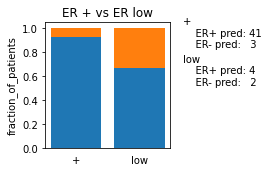

In [27]:
#ER low barplot
fig,ax = plt.subplots(figsize=(4,2.5))
padding = 0

for i,status in enumerate(['+','low']):
    current = probabilities[(probabilities['revisions_ER_status']==status)]
    rect = ax.bar(status, 1, color = 'tab:orange', label = 'predicted_ER_negative', width = 0.8)
    rect = ax.bar(status, current['median_prediction'].mean(), color = 'tab:blue', label = 'predicted_ER_positive', width = 0.8)
    text = status+\
    '\n    ER+ pred: '+str(sum(current['median_prediction']))+\
    '\n    ER- pred:   '+str(len(current) - sum(current['median_prediction']))
    ax.text(1.1,.8-i*.3,text,transform = ax.transAxes)
    
ax.set_ylabel('fraction_of_patients')
ax.set_title('ER + vs ER low')


ax.set_ylim(0,1.05)
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
ax.set_yticks(np.arange(0,1.05,.2))
plt.tight_layout()
plt.tick_params(bottom = False)
fig.savefig('plots/ER_low_barplot.pdf')

In [28]:
#er positive wrong samples have two ER low
#1405 is an ER- patient, but they had multiple biopsies and the last one was ER+ (moderate)
ER_positive_wrong[['tumor_fraction','median_probability','revisions_ER_status','merged_PrimaryEstrogenStatus']]

,tumor_fraction,median_probability,revisions_ER_status,merged_PrimaryEstrogenStatus
sample,,,,
MBC_1092_3_ULP,0.1015,0.46459,+,+
MBC_1116_3_ULP,0.3978,0.00384,low,low
MBC_1133_2_ULP,0.1846,0.43934,+,+
MBC_1390_2_ULP,0.2021,0.34198,+,+
MBC_1399_3_ULP,0.1308,0.11206,low,+
